In [1]:
import h5py
from datahandler import *

#### Ploting parameters

In [2]:
# Set global plot parameters
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titlepad'] = 10  # Adjust title padding if necessary
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 0.25
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['black'])
plt.rcParams['legend.fontsize'] = 6

## Set parameters

In [3]:
path = r'\\research.files.med.harvard.edu\Neurobio\Fishell Lab\Shuhan_HMS folder\NGFC\2P\NGFC' 
stimuli_file_path = path + r'\NGFC_Vis_Stimuli_SH_v4.4.3\Seq_stimuli'

#### Set file directory and parameters

type_name: <br/>
NP11 - 'Lamp5 Ai195 L1' & 'Lamp5 Ai195 L23'

In [4]:
type_name = 'Lamp5 Ai195 L23'
folder = r'\NP11_DlxCre;Lamp5FlpO;Ai195\NP11N\NP11N_ROI1_082222'
directory_path = path + folder

VIDEO_FRAMERATE = 19.06 #Hz
BASE_DEPTH = -188
DELTA_Z = 50
GCAMP='7s'

In [5]:
image_filename = r'\NP11N_ROI1_image1'
speed_filename = r'\NP11N_ROI1_speed1.npy'
behavior_filename = r'\NP11N_ROI1_record1_proc.npy'
stimuli_type = 'A'

#### Set stimulation parameters


In [6]:
StimulusData = StimulusDataHandler(stimuli_file_path=stimuli_file_path,
                                   stimuli_type=stimuli_type,
                                   printInfo=True)

[stimuli_seq, stimuli_list,
 stimuli_file, stimuli_type_doc] = StimulusData.read_StimuliType()

Stimuli Information
stimuli_type: A
stimuli_type_doc: spontaneous, dark
stimuli_file: 
stimuli_seq: []
stimuli_list: []


---
## Process imaging data
Imaging data were 30Hz calcium imaging from Suite2P

Output files: dict_keys(['F.npy', 'Fneu.npy', 'iscell.npy', 'ops.npy', 'spks.npy', 'stat.npy'])
Shape of 'FwithFneu': (36, 22000)
Shape of 'Fneu': (36, 22000)
Shape of 'iscell': (36, 2)
Type of 'ops': <class 'dict'>
Shape of 'spks': (36, 22000)
spike deconvolution is not used in all data, so 'spks' maybe empty or miscalculated.
shape of 'F':  (14, 22000)
Number of ROI/cells: num_roi = 14
Index of detected cells (ROIs): ind_cells = 
 [ 1  2  3  6  8  9 10 12 13 14 15 16 17 18]
location of detected cells (y,x,depth): 'roi_loc_with_depths' = 
 [[ 220.          84.        -167.6875   ]
 [ 356.         244.        -196.59375  ]
 [ 308.         284.        -195.8125   ]
 [ 157.          13.        -154.6015625]
 [  68.          60.        -150.5      ]
 [ 468.         172.        -200.5      ]
 [ 196.         304.        -186.828125 ]
 [ 420.         284.        -206.75     ]
 [  72.         492.        -193.078125 ]
 [ 464.          60.        -189.171875 ]
 [ 440.         400.        -220.

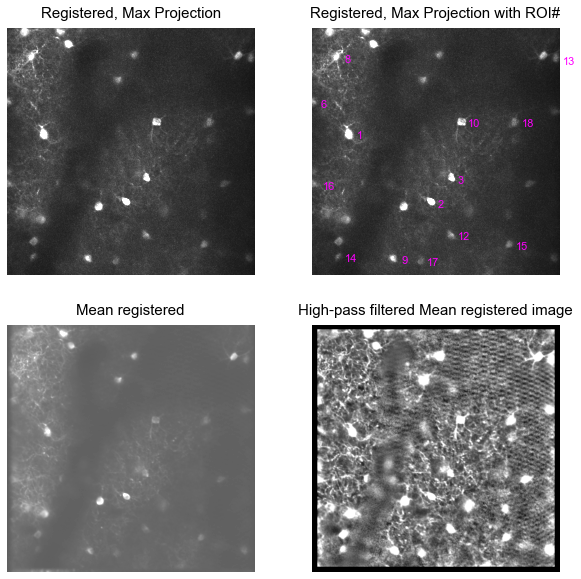

In [7]:
CalciumData = CalciumDataHandler(directory_path, 
                                  image_filename, 
                                  base_depth=BASE_DEPTH, 
                                  delta_z=DELTA_Z, 
                                  gcamp_type=GCAMP, 
                                  print_info=True, 
                                  file_format='tif')

[F, FwithFneu, Fneu, iscell, ops, spks, stat, 
 # F has substracted Fneu * neurophil factor
 roi_loc, stat_orig, ind_cells, num_roi] = CalciumData.read_Suite2p()


In [8]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# key = 'max_proj'
# vmin_val, vmax_val = None, None
# ax.imshow(ops[key], vmin=vmin_val, vmax=vmax_val, cmap='gray')
# ax.axis('off')
# figure_dir = os.path.join(directory_path, 'Figure')
# fig.savefig(os.path.join(figure_dir, f'[REP]_{image_filename[1:]}.tif'), dpi=300, transparent=True)

### Get standardized_dF_F0, baseline F0, dF_F0 and check the signal quality of each ROIs

In [9]:
standardized_dF_F0, F0, dF_F0 = CalciumData.standard_dF_F0(window_size=150, # 150-s window
                                                           percentile=30, 
                                                           plot=True)

KeyboardInterrupt: 

---
## Process speed data
Speed data from wheels, preprocessed, smoothed via **convolve1d** with uniform weighting (ones) filter with full-length window, and saved as .npy file in **[1] ReadSpeed mat to npy.ipynb**

#### Binning speed to 30Hz as imaging frame rate, transform to cm/s

In [ ]:
SpeedData = SpeedDataHandler(directory_path, 
                             speed_filename,
                             add_one=True, 
                             file_format='tif')

speed = SpeedData.binning_speed()

---
## Process behavior data
Behavior data from Facemap (All data were replaced with NaNs at the first 2s and last frame): 

(1) **motion_SVD** (raw from facemap, unsmoothed), 

(2) **video_running** (raw from facemap, unsmoothed), 

(3) **merged_blinks** (detect blinks with deviation period added before and after blink, and merge nearby blinks), <br/> 
**timestamps** (For each blink, four equally spaced time points are required. t2 is the blink onset; t3 is
the blink offset; t1=t2-t3+t2; t4=t3-t2+t3),

(4) **blink_zscored** (blink data raw from facemap, after z-score), <br/>
**blink_zscored_smooth_velocity** (velocity of smoothed blink z-score data),

(5) **pupil_area_smooth** (raw from facemap), <br/> 
**pupil_zscored** (after z-score), <br/> 
**pupil_nan** (after replacing blinks with NaN on pupil_zscored), <br/> 
**pupil_nan_smooth** (smoothed **pupil_nan**), <br/>
**pupil_interpolated** (Based on these **timestamps** and the associated pupil sizes (from the original, unsmoothed signal), a cubic-spline fit is generated. The original signal between t2 and t3 is replaced by the cubic spline. Thus, the signal is left unchanged, except for the blink period), <br/>
**pupil_interpolated_smooth** (Smoothed **pupil_interpolated**)

(6) **pupil_com** (center of mass in pixel, substracted from mean, [Y,X]), <br/> 
**pupil_com_nan** (after replacing blink with NaN), <br/> 
**pupil_com_nan_smooth** (smoothed **pupil_com_nan**), <br/>
**pupil_com_interpolated** (with cubic-spline interpolation), <br/> 
**pupil_com_interpolated_smooth** (Smoothed **pupil_com_interpolated**)

In [ ]:
BehaviorData = BehaviorDataHandler(directory_path, 
                                   behavior_filename, 
                                   VIDEO_FRAMERATE, 
                                   time_from_start=2, #default 2
                                   window_size=19, #default 19
                                   velocity_threshold=-0.15, #default -0.15
                                   zero_threshold=0.02, #default 0.02
                                   deviation_onset=10, #default 10
                                   deviation_offset=15, #default 15
                                   merge_threshold=10, #default 10
                                   y_lim=None,
                                   file_format='tif')

[video_motSVD, 
 video_running,
 merged_blinks, timestamps, 
 blink_zscored, blink_zscored_smooth_velocity,
 pupil_area_smooth, pupil_zscored, 
 pupil_nan, pupil_nan_smooth, 
 pupil_interpolated, pupil_interpolated_smooth,
 pupil_com, 
 pupil_com_nan, pupil_com_nan_smooth, 
 pupil_com_interpolated, pupil_com_interpolated_smooth] = BehaviorData.read_video()

# plot the data to check
BehaviorData.plot_video()

#### (optional) remove the bad frames of behavior

In [ ]:
# parameters_list = [pupil_zscored, 
#                    pupil_nan, pupil_nan_smooth, 
#                    pupil_interpolated, pupil_interpolated_smooth,
#                    pupil_com, pupil_com_nan, pupil_com_nan_smooth, 
#                    pupil_com_interpolated, pupil_com_interpolated_smooth]

# for para in parameters_list:
#     para[:int(np.ceil(2*VIDEO_FRAMERATE))] = np.nan

---
## Save processed data for downstream analysis
Data from suite2p processing are stored in suite2p folder, so they are not saved here.

In [ ]:
data_to_save = {
    # basic experiment parameters
    'type_name': type_name,
    'path': path,
    'folder': folder,
    'directory_path': directory_path,
    
    'image_filename': image_filename,
    'speed_filename': speed_filename,
    'behavior_filename': behavior_filename,

    'VIDEO_FRAMERATE': VIDEO_FRAMERATE, # confirm the frame_rate of videos
   
    'BASE_DEPTH': BASE_DEPTH,
    'DELTA_Z': DELTA_Z,
    'GCAMP': GCAMP,
    
    'roi_loc': roi_loc, # (y, x, z)
    'ind_cells': ind_cells,
    'num_roi': num_roi,
    
    # Imaging data are all 30Hz
    'F': F, # F has substracted Fneu * neurophil factor
    'F0': F0, # baseline
    'dF_F0': dF_F0,
    'standardized_dF_F0': standardized_dF_F0, # ∆F/F0 traces were standardized by subtracting the median and dividing by the standard deviation.
    
    # Speed data saved as 30Hz
    'speed': speed, # smoothed and binned speed (30Hz), in cm/s

    # Video data are saved as original VIDEO_FRAMERATE.
    'video_motSVD': video_motSVD, # (frames, 500) Nose and face region (raw from facemap, unsmoothed)
    'video_running': video_running, # (frames, 2) running speed from video (raw from facemap, unsmoothed)

    'merged_blinks': merged_blinks, # (each blink, 2) 2-on and off; the on and off frame index for each blink
    'timestamps': timestamps, # (four data points for each blink)
    'blink_zscored': blink_zscored, # (frames,) z-scored blink data
    'blink_zscored_smooth_velocity': blink_zscored_smooth_velocity, # velocity of smoothed blink_zscored
    
    'pupil_area_smooth': pupil_area_smooth, # list of pupil area_smooth outputs from Facemap
    'pupil_zscored': pupil_zscored, # pupil_area_smooth after z-score
    'pupil_nan': pupil_nan, # pupil_area_zscored after replacing blinks + deviation periods with NaN
    'pupil_nan_smooth': pupil_nan_smooth,
    'pupil_interpolated': pupil_interpolated, # pupil_zscored with CubicSpline interpolation
    'pupil_interpolated_smooth': pupil_interpolated_smooth,
    
    'pupil_com': pupil_com, # pixel, center of mass, substracted from mean, [Y,X]
    'pupil_com_nan': pupil_com_nan, # pupil_com after replacing blinks + deviation periods with NaN
    'pupil_com_nan_smooth': pupil_com_nan_smooth,
    'pupil_com_interpolated': pupil_com_interpolated, # pupil_com_nan with 1d interpolation
    'pupil_com_interpolated_smooth': pupil_com_interpolated_smooth,
    
    # Stimulation
    'stimuli_file_path': stimuli_file_path,
    'stimuli_file': stimuli_file,
    'stimuli_type': stimuli_type,
    'stimuli_type_doc': stimuli_type_doc,
    'stimuli_seq': stimuli_seq,
    'stimuli_list': stimuli_list
}

# Define the path for the HDF5 file
hdf5_file_dir = os.path.join(directory_path, 'Data')
if not os.path.exists(hdf5_file_dir):
    os.makedirs(hdf5_file_dir)
hdf5_file_path = hdf5_file_dir + image_filename +'_data.h5' 

# Create a new HDF5 file
with h5py.File(hdf5_file_path, 'w') as h5f:
    # Loop over the data and save each dataset
    for key, value in data_to_save.items():
        h5f.create_dataset(key, data=value)

In [ ]:
print('Finished')